## Imports

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (50.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

### Import Packages

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

import pandas_datareader.naver as web_naver

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
idx = pd.IndexSlice
sns.set(font='NanumBarunGothic',
       rc={'axes.unicode_minus':False},
       style='darkgrid')
plt.rc('font', family='NanumBarunGothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
sns.set_style('whitegrid')
np.random.seed(42)

### Import data

In [ ]:
krx100 = pd.read_csv('KRX100.csv', encoding='cp949')
krx100.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [ ]:
krx300 = pd.read_csv('KRX300.csv', encoding='cp949')
krx300.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,660,SK하이닉스,98700,4700,5.00,71853833.0
2,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
3,5380,현대차,183500,1000,0.55,39208112.0
4,35420,NAVER,231000,-2500,-1.07,37895339.0


In [ ]:
kospi200 = pd.read_csv('KOSPI200.csv', encoding='cp949')
kospi200.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [ ]:
kosdaq150 = pd.read_csv('KOSDAQ150.csv', encoding='cp949')
kosdaq150.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,91990,셀트리온헬스케어,70500,-800,-1.12,11149919.0
1,247540,에코프로비엠,111500,-5500,-4.70,10904850.0
2,66970,엘앤에프,207500,-5500,-2.58,7455395.0
3,28300,HLB,42800,250,0.59,4574581.0
4,293490,카카오게임즈,49400,-2100,-4.08,3887740.0


In [ ]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2021,1,1)
#dataset = pd.concat([kospi200, kosdaq150], axis=0)
#dataset = krx100
dataset = krx300

In [ ]:
def import_price_data(start, end, dataset):
    dictionary = {}
    code_list = dataset['종목코드'].tolist()
    name_list = dataset['종목명'].tolist()
    for i in range(len(code_list)):
        code = str(code_list[i]).zfill(6)
        name = name_list[i]
        df = web_naver.NaverDailyReader(symbols=code, start=start, end=end, adjust_price=True).read()
        adj_close = df.Close
        dictionary[name] = adj_close
    data = pd.DataFrame(dictionary)
    data = data.astype('float')
    return data

In [ ]:
df = import_price_data(start, end, dataset)

In [ ]:
# 10% 이상의 결측치가 존재하면 그 종목은 사용하지 않기로 한다.
def dropna_percent(percentage, dataset):
    print('결측치 존재 여부: ', dataset.isnull().values.any())
    missing_fraction = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fraction[missing_fraction > percentage].index))
    new_df = dataset.drop(labels=drop_list, axis=1)
    print(f"제거한 column의 수는 {len(drop_list)}개 입니다.")
    return new_df

In [ ]:
df = dropna_percent(0.05, df)

결측치 존재 여부:  True
제거한 column의 수는 93개 입니다.


In [ ]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
print(df.shape)
print('결측치 존재 여부: ', df.isnull().values.any())

(2215, 207)
결측치 존재 여부:  False


In [ ]:
train = df[df.index < '2019-01-01']
test = df[df.index > '2019-01-01']

## Finding pair

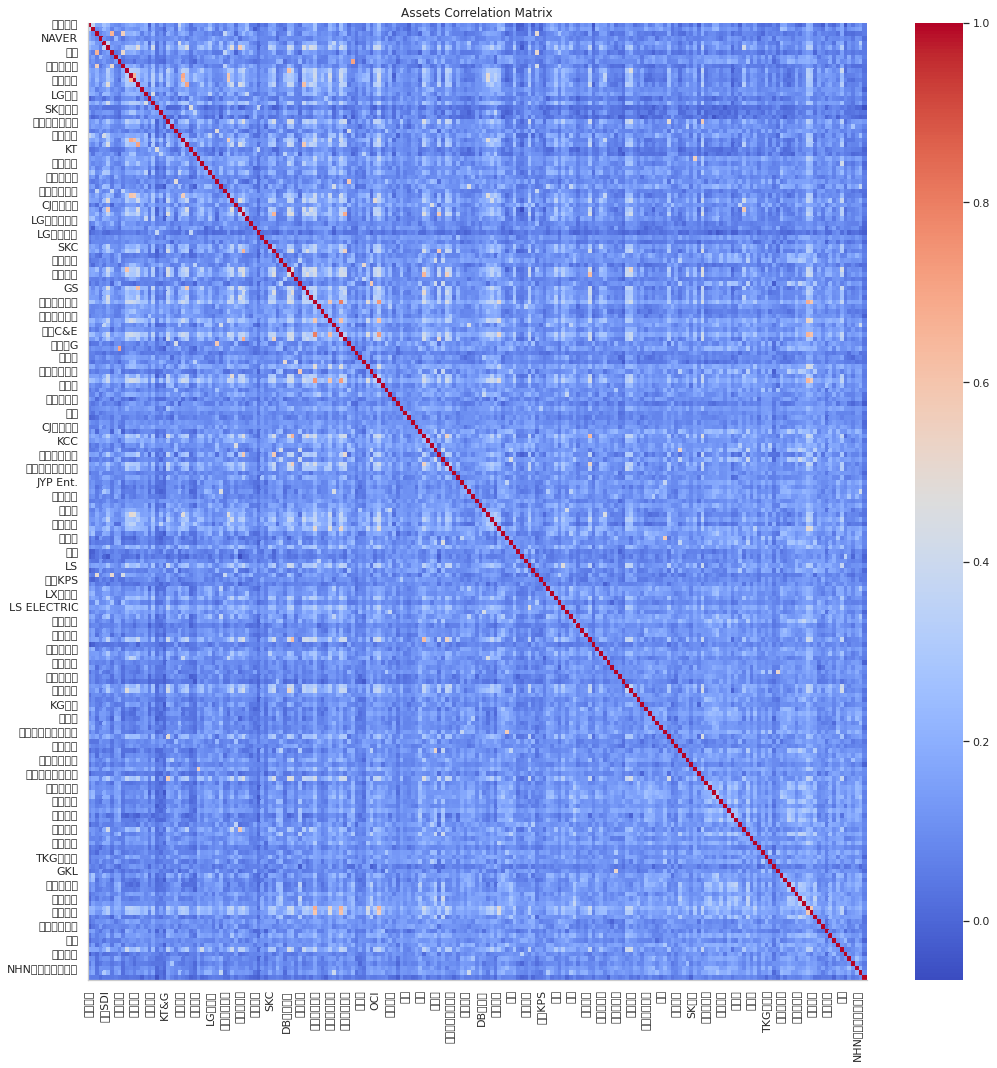

In [ ]:
# Spearman correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.pct_change().corr(method ='spearman'),ax=ax, cmap='coolwarm')
ax.set_title('Assets Correlation Matrix')
sns.despine()
plt.tight_layout()

In [ ]:
def find_cointegrated_pairs(data, p_value):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < p_value:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [ ]:
pvalues, pairs = find_cointegrated_pairs(train, 0.01)
print("페어의 개수: ", len(pairs))
print(pairs)

100%|██████████| 207/207 [24:58<00:00,  7.24s/it]

페어의 개수:  392
[('삼성전자', 'KB금융'), ('삼성전자', '현대해상'), ('삼성전자', '후성'), ('삼성전자', '에스에프에이'), ('현대차', '삼성중공업'), ('현대차', '대우조선해양'), ('현대차', '포스코인터내셔널'), ('현대차', 'DGB금융지주'), ('현대차', '현대바이오'), ('현대차', '메디톡스'), ('현대차', '부광약품'), ('현대차', '아난티'), ('삼성SDI', '동양생명'), ('LG화학', 'S-Oil'), ('카카오', '기업은행'), ('셀트리온', 'HLB'), ('셀트리온', '대웅제약'), ('셀트리온', '신풍제약'), ('셀트리온', 'HLB생명과학'), ('현대모비스', 'SK'), ('현대모비스', 'SK텔레콤'), ('현대모비스', '두산에너빌리티'), ('현대모비스', 'LG생활건강'), ('현대모비스', '삼성화재'), ('현대모비스', '한국조선해양'), ('현대모비스', 'LG유플러스'), ('현대모비스', '삼성중공업'), ('현대모비스', 'HLB'), ('현대모비스', '한국금융지주'), ('현대모비스', '쌍용C&E'), ('현대모비스', '메리츠금융지주'), ('현대모비스', '메리츠증권'), ('현대모비스', 'OCI'), ('현대모비스', '롯데쇼핑'), ('현대모비스', '한솔케미칼'), ('현대모비스', '에스원'), ('현대모비스', '한전기술'), ('현대모비스', '대우조선해양'), ('현대모비스', '대웅제약'), ('현대모비스', '대우건설'), ('현대모비스', '포스코인터내셔널'), ('현대모비스', '한화에어로스페이스'), ('현대모비스', '리노공업'), ('현대모비스', '대웅'), ('현대모비스', 'LS'), ('현대모비스', '오뚜기'), ('현대모비스', '휠라홀딩스'), ('현대모비스', 'DGB금융지주'), ('현대모비스', '동화기업'), ('현대모비스', '현대바이오'), ('현대모비스', 'HLB생명과학'), ('현

## Perform EDA and Cointegration test for Selected pair

### Choose one pair

In [ ]:
asset1 = '삼성전자'
asset2 = 'KB금융'

In [ ]:
pair1 = pd.DataFrame()
pair1[asset1] = train[asset1]
pair1[asset2] = train[asset2]

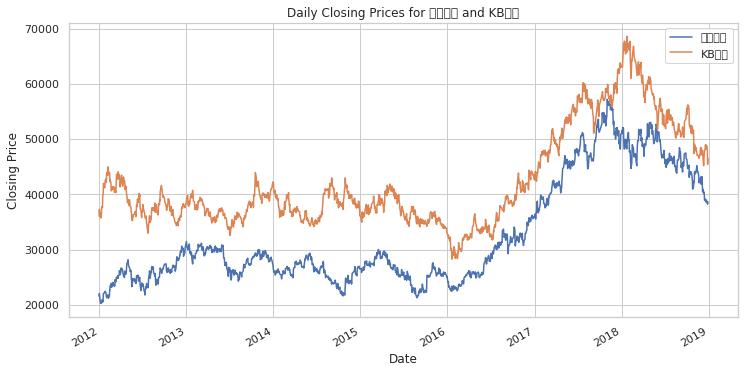

In [ ]:
# 두 자산의 움직임을 시각화
ax = pair1[[asset1, asset2]].plot(figsize=(12, 6))
ax.set_title('Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

### Calculate spread and ratio

In [ ]:
# run OLS regression
model=sm.OLS(pair1.삼성전자, pair1.KB금융).fit()

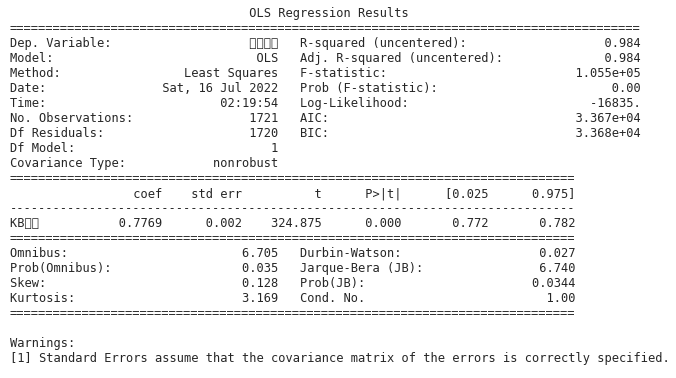

In [ ]:
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

In [ ]:
# calculate spread
spread = pair1.삼성전자 - model.params[0] * pair1.KB금융

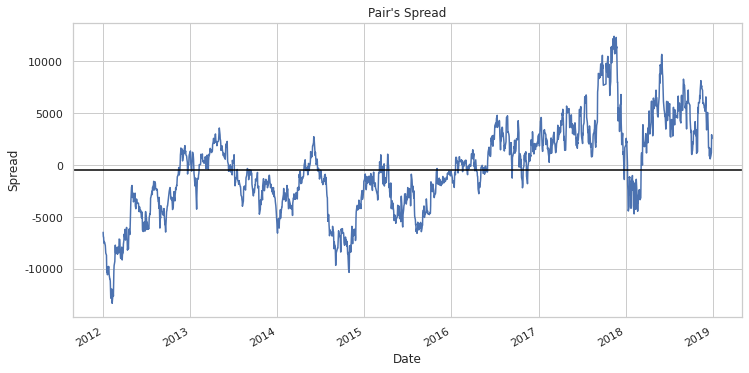

In [ ]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.axhline(spread.mean(), color='black')
ax.set_ylabel("Spread")
ax.grid(True)

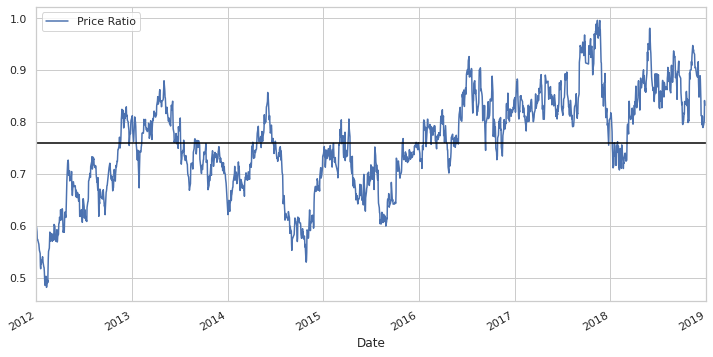

In [ ]:
# Price ratio를 그리기
ratio = pair1.삼성전자 / pair1.KB금융
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['Price Ratio'])

In [ ]:
# ADF test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.559992955927844


## Generate Trading Signals using z-score

In [ ]:
# calculate z-score
def zscore(series):
    return (series-series.mean()) / np.std(series)

In [ ]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['삼성전자'] = train['삼성전자'] 
signals['KB금융'] = train['KB금융']
ratios = signals.삼성전자 / signals.KB금융

In [ ]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * 2
signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * 2

In [ ]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [ ]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

In [ ]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

,삼성전자,KB금융,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2012-01-02,21600.0,36100.0,-1.678635,2.0,-2.0,0,NaN,0,NaN
2012-01-03,22100.0,37300.0,-1.739739,2.0,-2.0,0,0.0,0,0.0
2012-01-04,21600.0,36700.0,-1.780903,2.0,-2.0,0,0.0,0,0.0
2018-12-26,38350.0,47800.0,0.453708,2.0,-2.0,0,0.0,0,0.0
2018-12-27,38250.0,45450.0,0.864392,2.0,-2.0,0,0.0,0,0.0
2018-12-28,38700.0,46500.0,0.766892,2.0,-2.0,0,0.0,0,0.0


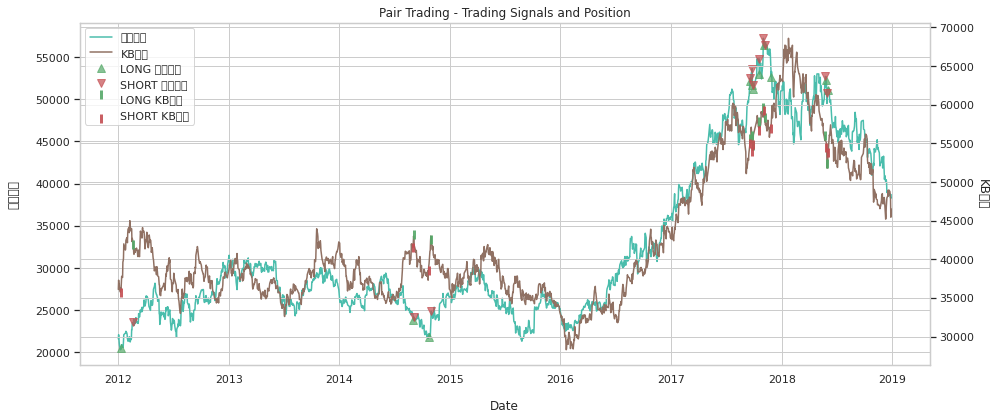

In [ ]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['삼성전자'], c='#4abdac')
l2, = bx2.plot(signals['KB금융'], c='#907163')

u1, = bx.plot(signals['삼성전자'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['삼성전자'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['KB금융'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['KB금융'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format("삼성전자"),
           'SHORT {}'.format("삼성전자"),
           'LONG {}'.format("KB금융"),
           'SHORT {}'.format("KB금융")], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

## Portfolio Profit and Loss Calculation

In [ ]:
# initial capital to calculate the actual pnl
initial_capital = 1e8 / 2

# shares to buy for each position
positions1 = initial_capital// max(signals['삼성전자'])
positions2 = initial_capital// max(signals['KB금융'])

In [ ]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['삼성전자'] = signals['삼성전자']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['삼성전자'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['삼성전자'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [ ]:
portfolio['KB금융'] = signals['KB금융']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['KB금융'] * positions1
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['KB금융'] * positions1).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [ ]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

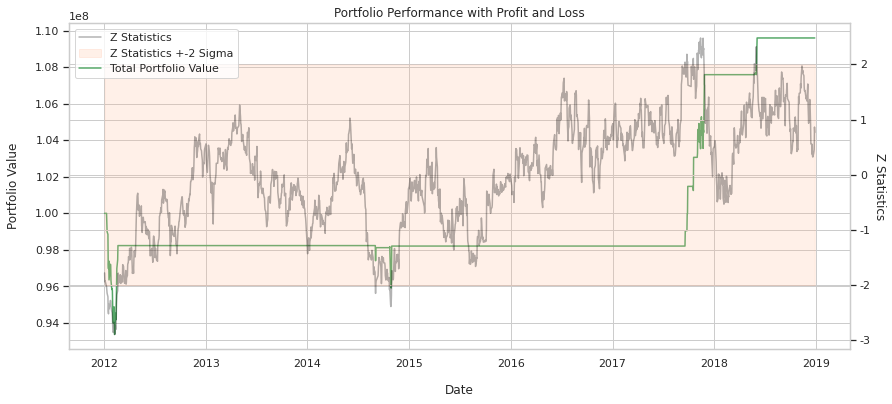

In [ ]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-2 Sigma',
                      'Total Portfolio Value'],loc='upper left')

In [ ]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  2550


In [ ]:
YEAR_DAYS = 252
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 0.909%


### Portfolio(All pairs)

In [ ]:
def trade(S1, S2, bound, initial_capital, train_set=True):
    if train_set:
        signals = pd.DataFrame()
        signals[S1] = train[S1] 
        signals[S2] = train[S2]
    else:
        signals = pd.DataFrame()
        signals[S1] = test[S1]
        signals[S2] = test[S2]
        
    ratios = signals[S1] / signals[S2]
    signals['z'] = zscore(ratios)
    signals['z upper limit'] = (np.mean(signals['z']) + np.std(signals['z'])) * abs(bound)
    signals['z lower limit'] = (np.mean(signals['z']) - np.std(signals['z'])) * abs(bound)
    
    signals['signals1'] = 0
    signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
    
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()
    
    # initial capital to calculate the actual pnl
    initial_capital = initial_capital/2

    # shares to buy for each position
    positions1 = initial_capital// max(signals[S1])
    positions2 = initial_capital// max(signals[S2])
    
    # since there are two assets, we calculate each asset Pnl separately 
    # and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = signals[S1]
    portfolio['holdings1'] = signals['positions1'].cumsum() * signals[S1] * positions1
    portfolio['cash1'] = initial_capital - (signals['positions1'] * signals[S1] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = signals['positions1']
    
    portfolio[S2] = signals[S2]
    portfolio['holdings2'] = signals['positions2'].cumsum() * signals[S2] * positions1
    portfolio['cash2'] = initial_capital - (signals['positions2'] * signals[S2] * positions1).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = signals['positions2']
    
    # total pnl and z-score
    portfolio['z'] = signals['z']
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = signals['z upper limit']
    portfolio['z lower limit'] = signals['z lower limit']
    portfolio = portfolio.dropna()
    
    total_asset = portfolio['total asset']
    
    return total_asset

In [ ]:
def pair_portfolio_return(pair_list, bound, initial_capital, train_set=True):
    capital = initial_capital/len(pair_list)
    if train_set:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0], pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=True)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = train.index[2:]
    else:
        total_return = []
        for pair in pair_list:
            S1, S2 = pair[0],pair[1]
            pair_return = trade(S1, S2, bound, capital, train_set=False)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = test.index[2:]
    return total_return

In [ ]:
total_df = pair_portfolio_return(pairs, 2, 1e10)

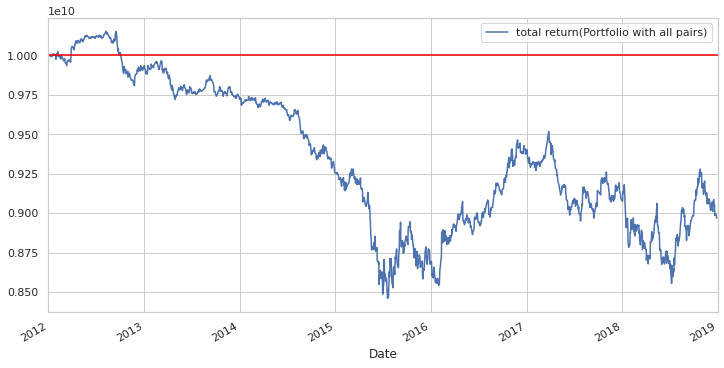

In [ ]:
total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['total return(Portfolio with all pairs)'])

## Backtest(Out of Sample)

### Backtest(2019~2021)

(737060.0, 737791.0)

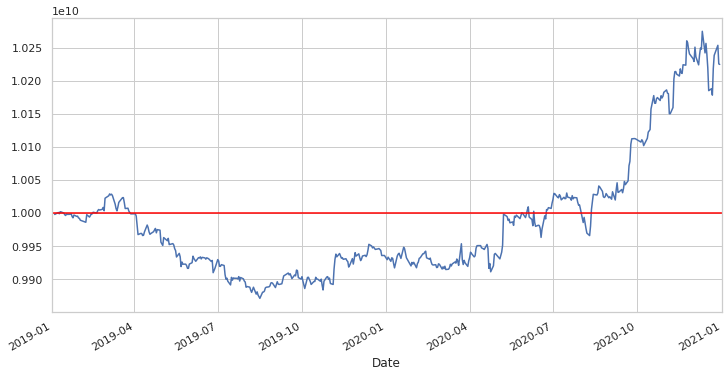

In [ ]:
total_df = pair_portfolio_return(pairs, 2, 1e10, train_set=False)

total_df.plot(figsize=(12,6))
plt.axhline(1e10, color='red')
plt.xlim('2019-01-01', '2021-01-01')